* What are the most popular technology fields for patents assigned in the last 5 years?
* What's the most frequent technology field by inventor's country? 

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
patent = pd.read_csv('data/pat63_99.txt',low_memory=False)
print ("lenght: ",len(patent))
patent.head()

lenght:  2923922


,PATENT,GYEAR,GDATE,APPYEAR,COUNTRY,POSTATE,ASSIGNEE,ASSCODE,CLAIMS,NCLASS,...,CRECEIVE,RATIOCIT,GENERAL,ORIGINAL,FWDAPLAG,BCKGTLAG,SELFCTUB,SELFCTLB,SECDUPBD,SECDLWBD
0,3070801,1963,1096,NaN,BE,NaN,NaN,1,NaN,269,...,1,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3070802,1963,1096,NaN,US,TX,NaN,1,NaN,2,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3070803,1963,1096,NaN,US,IL,NaN,1,NaN,2,...,9,NaN,0.3704,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3070804,1963,1096,NaN,US,OH,NaN,1,NaN,2,...,3,NaN,0.6667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3070805,1963,1096,NaN,US,CA,NaN,1,NaN,2,...,1,NaN,0.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
patent.groupby('CAT')['PATENT'].nunique()


CAT
1    606934
2    290337
3    204199
4    499741
5    681378
6    641333
Name: PATENT, dtype: int64

In [98]:
years=np.sort(patent["GYEAR"].unique())
time=[]
for year in years:
    current=patent[patent["GYEAR"]==year]
    numbers=current.groupby('CAT')['PATENT'].nunique()
    time.append(numbers)
time=pd.DataFrame(time)
time["Time"]=years
time=time.set_index("Time")

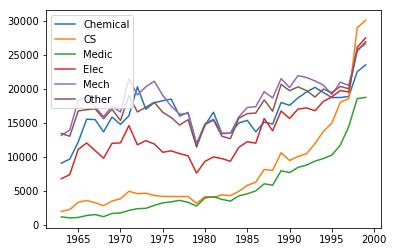

In [102]:
idxs=range(1,7)
names=["Chemical","CS","Medic","Elec","Mech","Other"]
for idx in idxs:
    plt.plot(years,time[idx],label=names[idx-1])
plt.legend(loc='upper left')
plt.show()

In [82]:
years=np.sort(patent["COUNTRY"].unique())
country=[]
for year in years:
    current=patent[patent["COUNTRY"]==year]
    numbers=current.groupby('CAT')['PATENT'].nunique()
    country.append(numbers)
country=pd.DataFrame(country)
country["Country"]=years
country=country.set_index("Country")

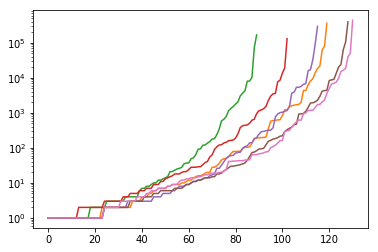

In [104]:
idxs=[1,2,3,4,5,6]
for idx in idxs:
    plt.plot(range(len(country)),np.sort(country[idx]))
plt.yscale('log')
plt.show()

In [85]:
len(country)

162